In [1]:
import numpy as np
from spiker import *
import matplotlib.pyplot as plt
from rnn import rnn

Sequence length is 2


(2, 300000)

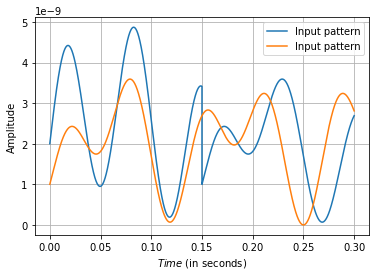

In [51]:
# Generate simulation data
def gen_data(nblocks,f1,f2, tstart=0, tstop=0.0001, Ts=1e-6,amp=1e-9):
    """
    Generates a time series comprising nblocks of data
    Each block is some combination of two sinusoids.
    nblocks = number of blocks
    tseries = Tseries object. Tseries is a datastructure 
        that makes it easy to deal with time-series data
    amp = Scales the entire data block
    """
    #np.random.seed(1)
    tseries = gen_time(tstart,tstop,Ts) # obtain the time series input sample
    time = tseries.time
    ip = np.array([])
    op = np.array([])
    tblockend = int(len(time)/nblocks)
    timeblock = time[:tblockend]
    for index in range(nblocks):
        if np.random.randint(2):
            block = 2*np.sin(2*np.pi*timeblock*f2)+1*np.sin(2*np.pi*timeblock*f1)+2
            ip = np.concatenate((ip,block))
            op = np.concatenate((op,np.zeros_like(timeblock)))
        else:
            block = 1*np.sin(2*np.pi*timeblock*f2)+2*np.sin(2*np.pi*timeblock*f1)**2+1
            ip = np.concatenate((ip,block))
            op = np.concatenate((op,np.ones_like(timeblock)))
    return amp*ip, amp*op, time
# Some input
ip1,_,tsteps = gen_data(nblocks=2, f1=4, f2=15, tstop=0.3)
ip2,_,tsteps = gen_data(nblocks=1, f1=4, f2=15, tstop=0.3)

print('Sequence length is {}'.format(len(ip)))
inp1 = Tseries(ip1, tsteps)
inp2 = Tseries(ip2, tsteps)
inp1.plot(label = "Input pattern")
inp2.plot(label = "Input pattern")
ip = np.stack((ip1,ip2))
ip.shape# = (1,ip.shape[0])

In [52]:
def set_all_weights_to_one(net):
    for idx in range(len(net.weights)):
        net.weights[idx] = np.ones_like(net.weights[idx])*1e-2

In [57]:
# Test case
ip_dim = ip.shape[0]
op_dim = 1
res_dim = 50
nrlayers = 1
seq_len = ip.shape[1]

net = rnn(nrlayers, ip_dim, res_dim, op_dim)
# set_all_weights_to_one(net)
ann_states = net.ann_forward(ip, mode='ann')
snn_states = net.ann_forward(ip, mode='snn')

Time constant = 676.930 sec
Average spike rate = 57.112 KHz


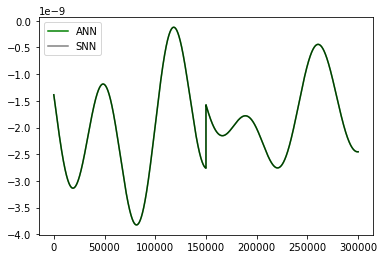

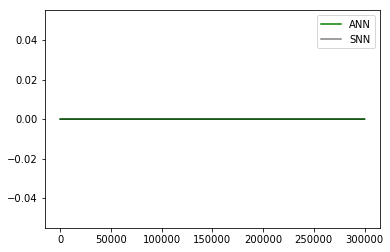

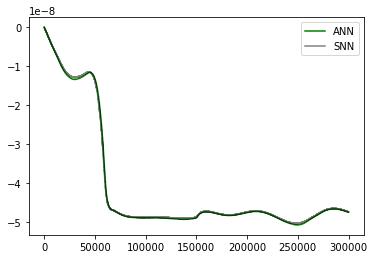

In [64]:
# Plotting and visualization
print('Time constant = {0:.3f} sec'.format(1/net.tau))
for idx in range(len(ann_states)):
    plt.figure()
    plt.plot(ann_states[idx][0,:],'g', label='ANN')
    plt.legend()
    plt.plot(snn_states[idx][0,:],'k', label='SNN', alpha=0.5)
    plt.legend()
t = 0
for N in net.neurons:
    t += np.sum(N.spike_count)
print('Average spike rate = {0:.3f} KHz'. format(1e-3*t/(tsteps[-1]*op_dim+res_dim+ip_dim)))

Time constant = 676.930 sec
Average spike rate = 57.112 KHz


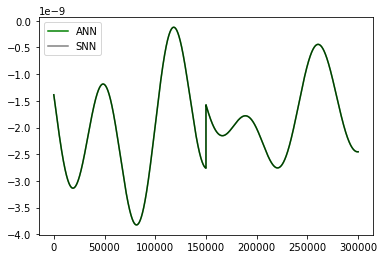

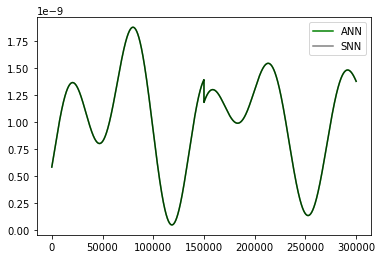

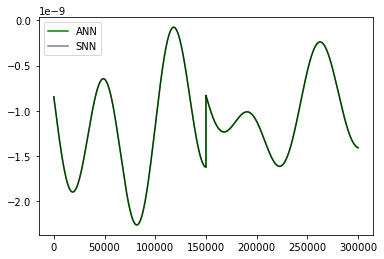

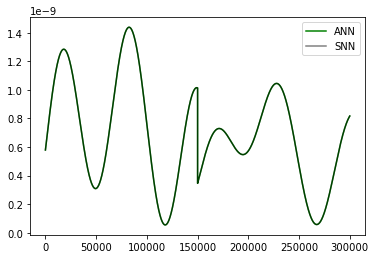

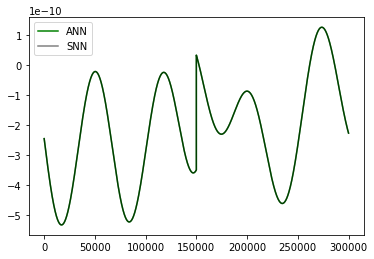

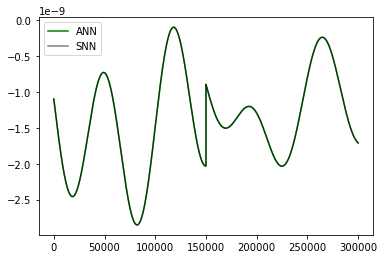

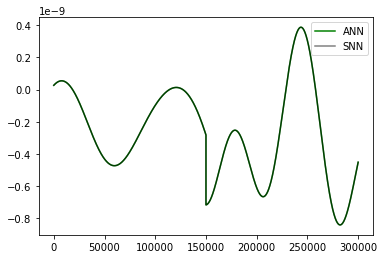

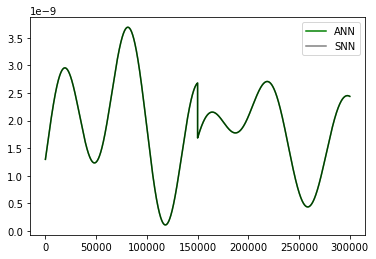

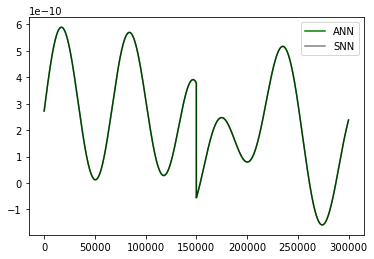

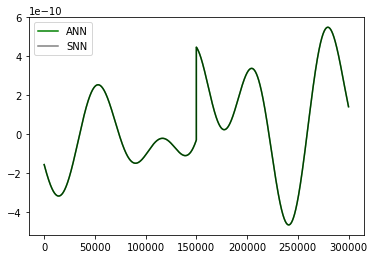

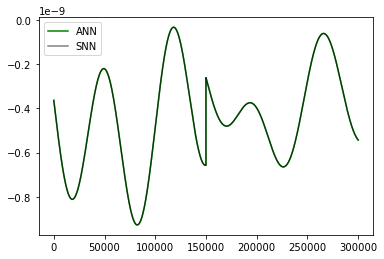

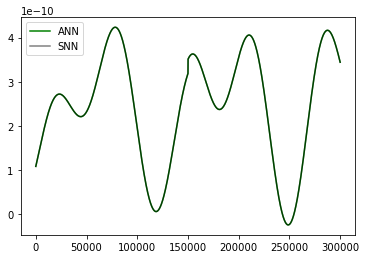

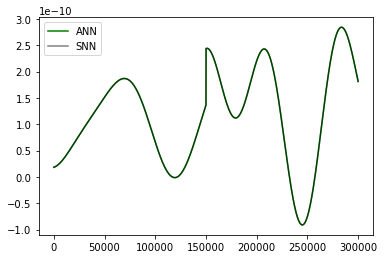

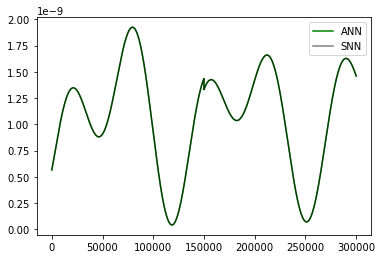

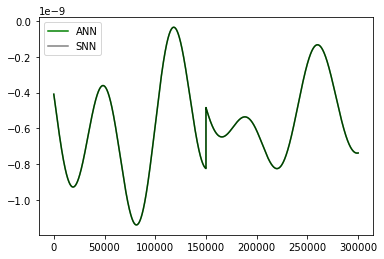

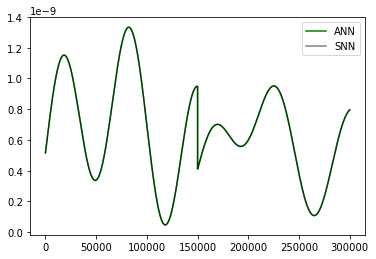

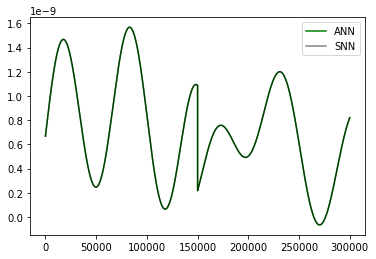

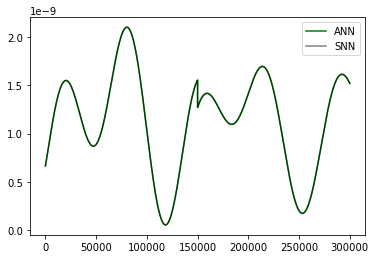

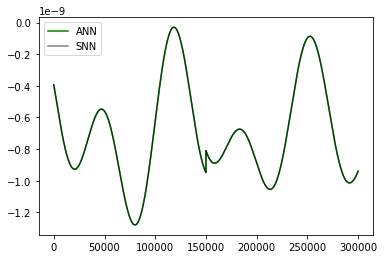

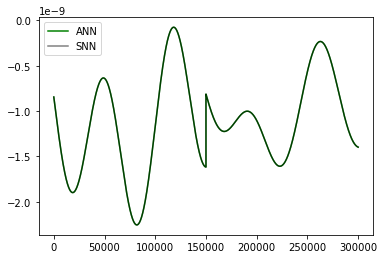

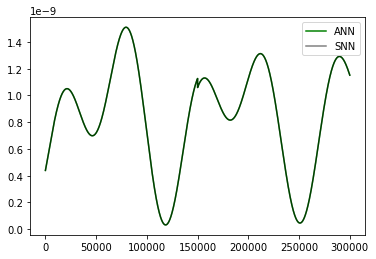

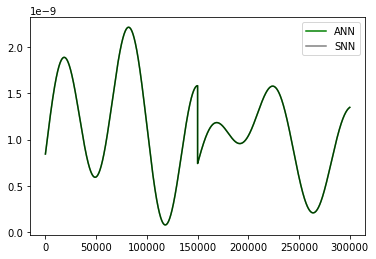

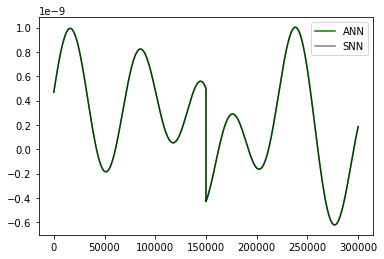

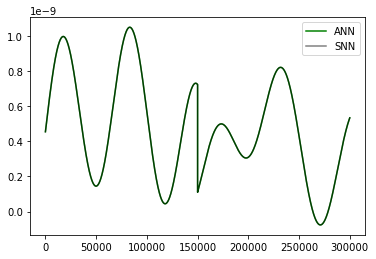

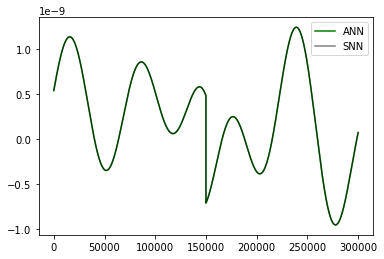

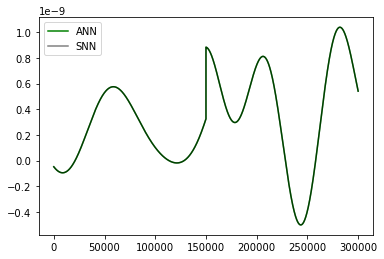

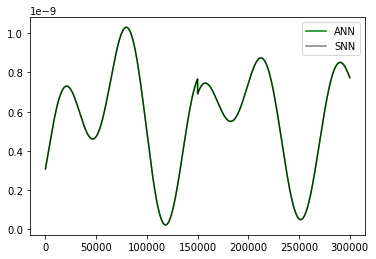

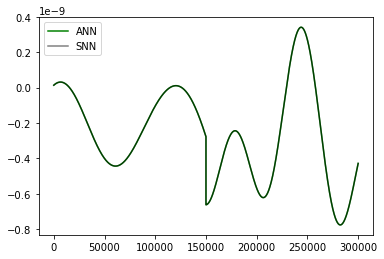

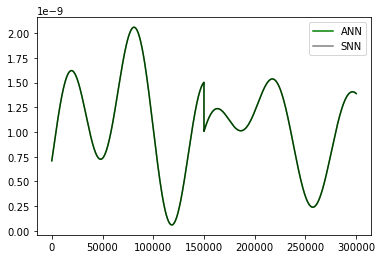

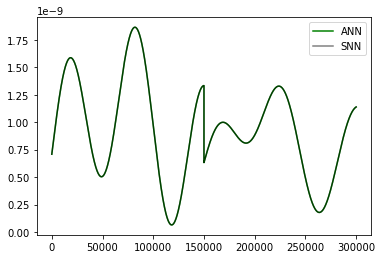

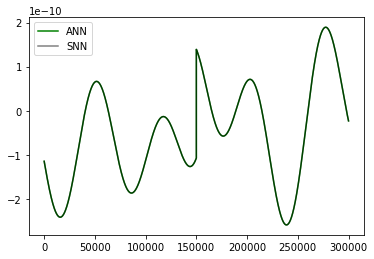

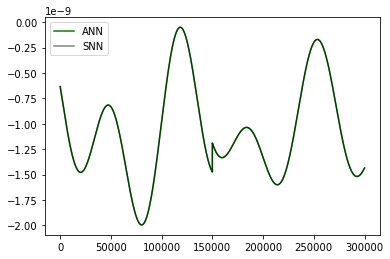

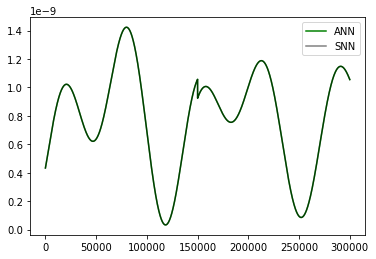

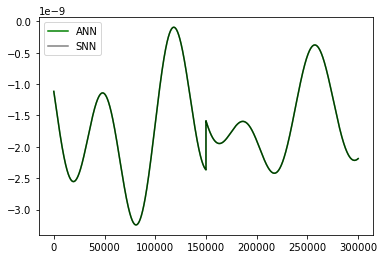

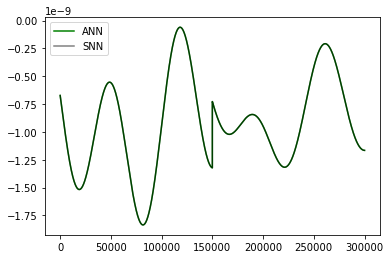

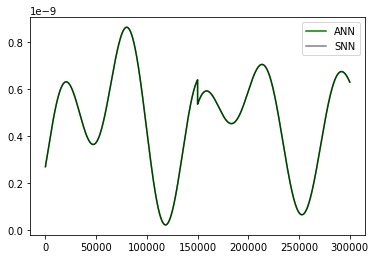

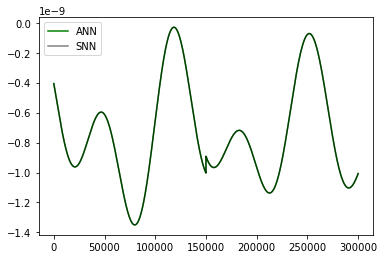

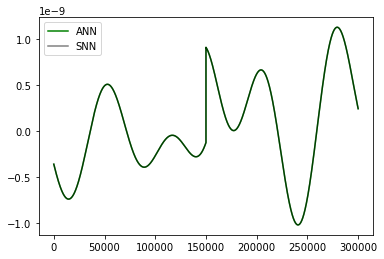

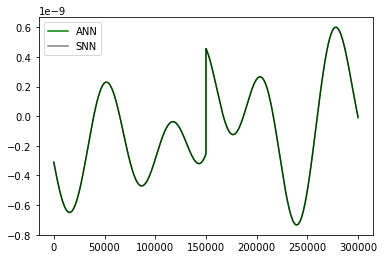

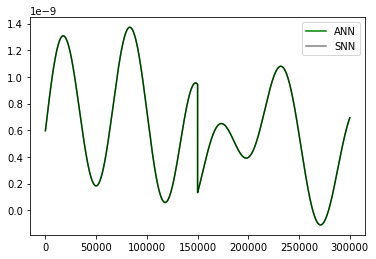

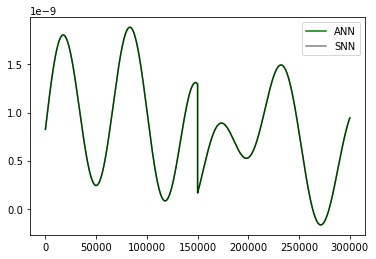

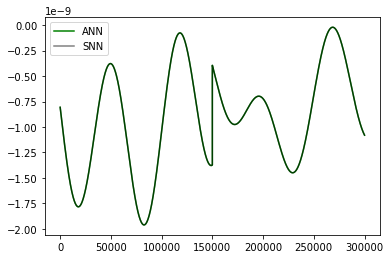

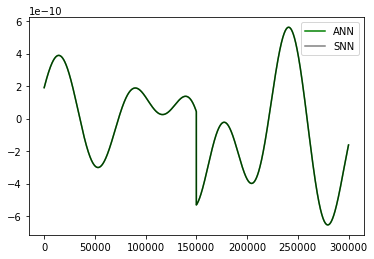

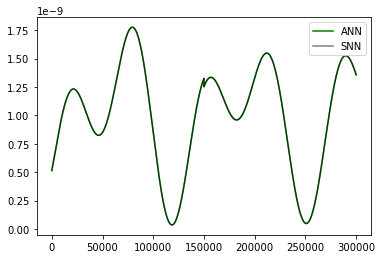

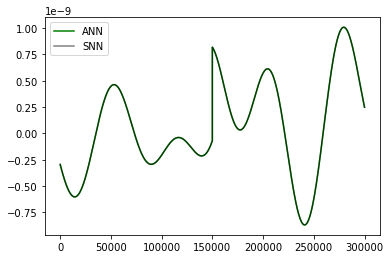

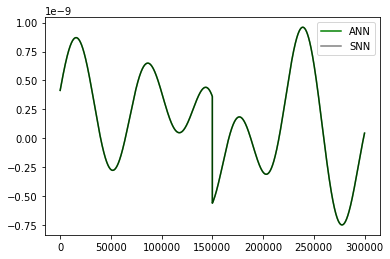

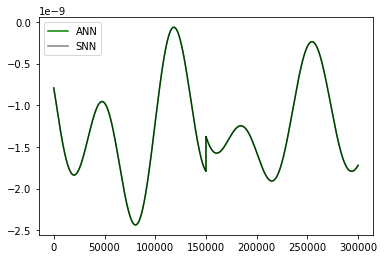

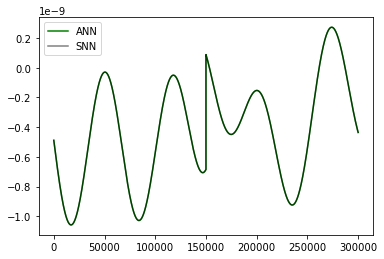

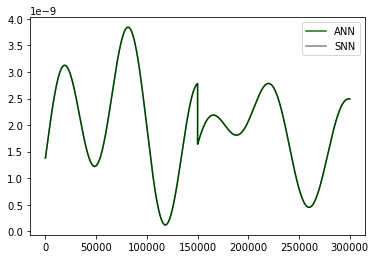

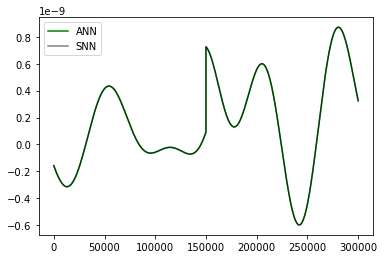

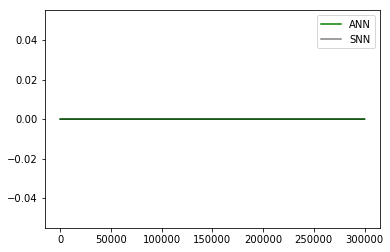

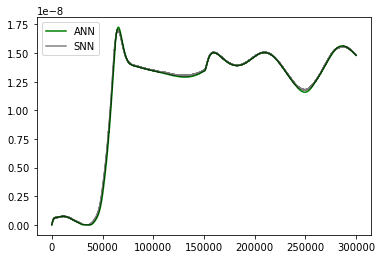

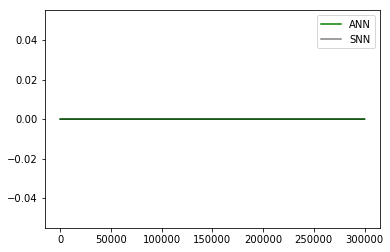

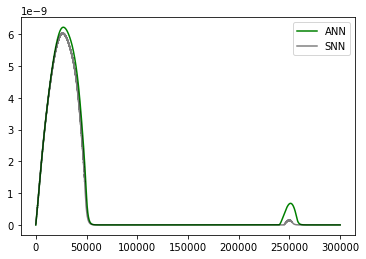

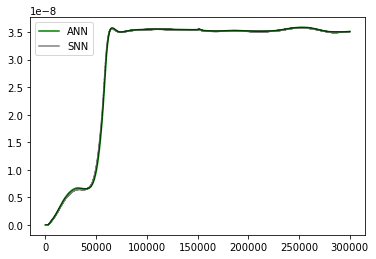

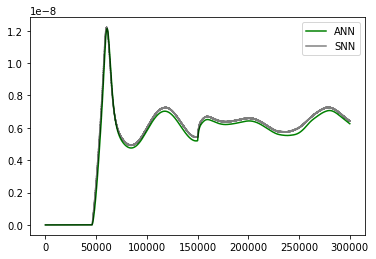

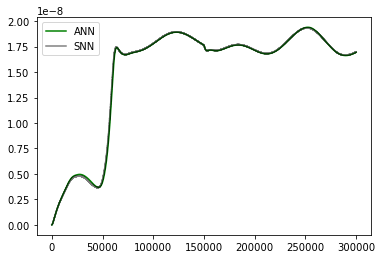

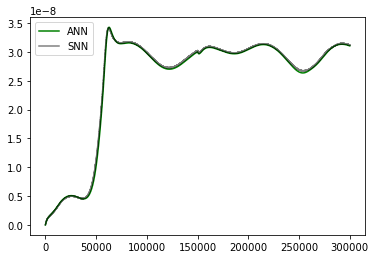

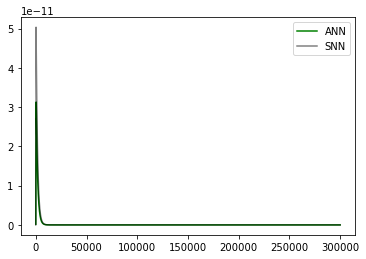

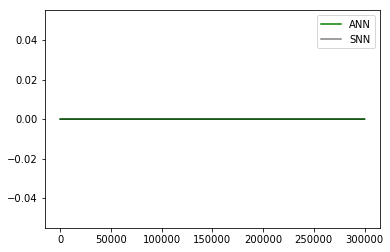

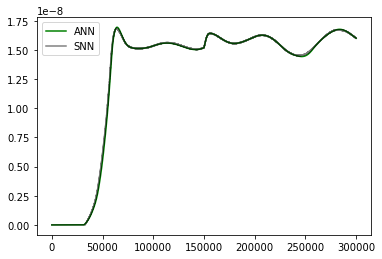

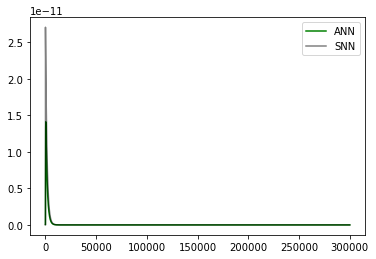

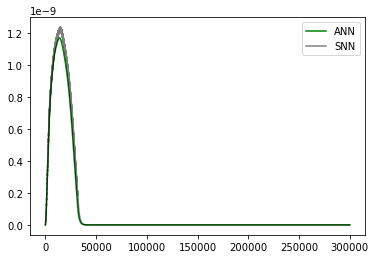

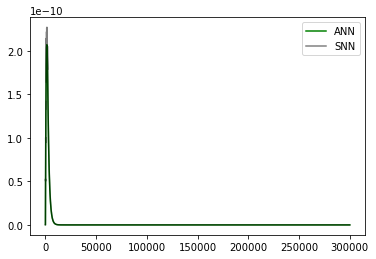

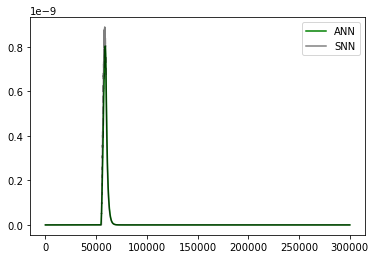

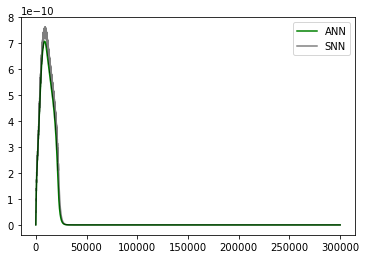

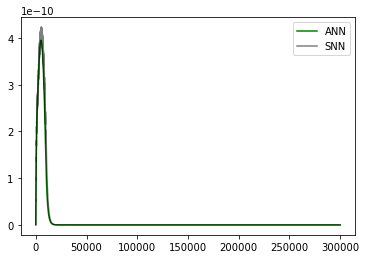

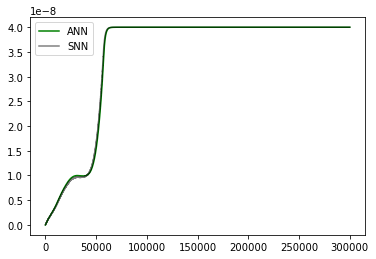

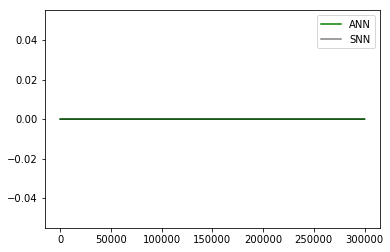

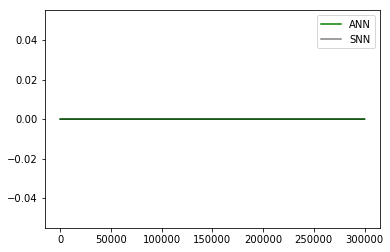

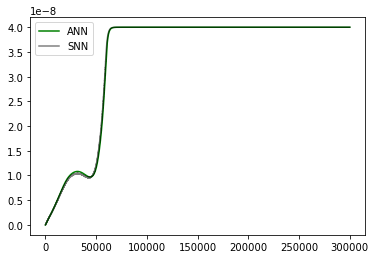

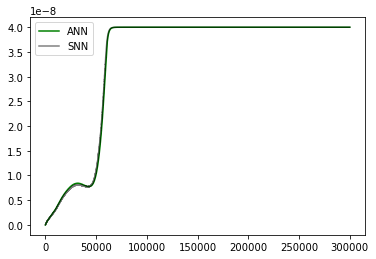

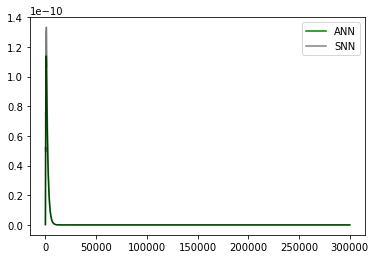

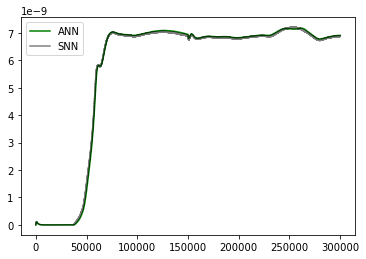

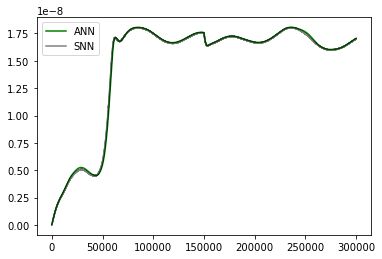

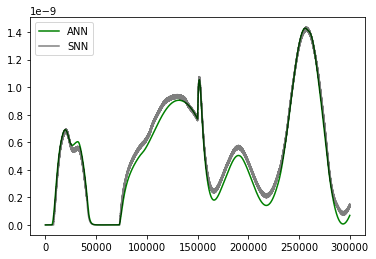

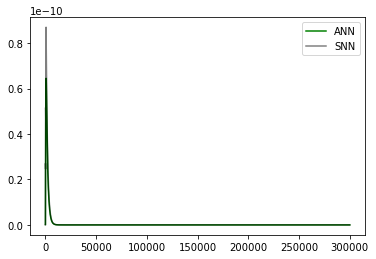

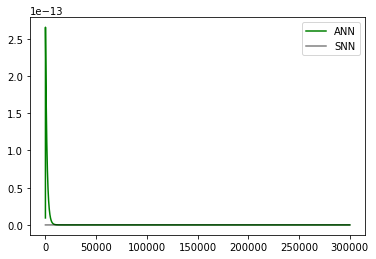

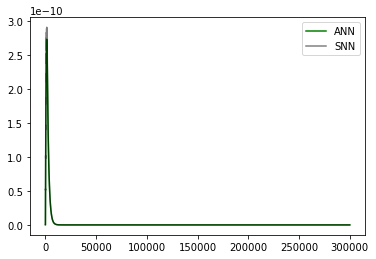

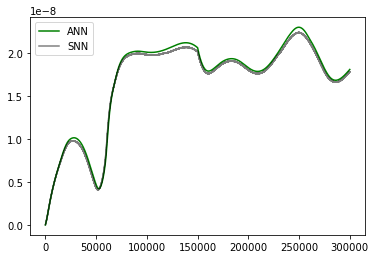

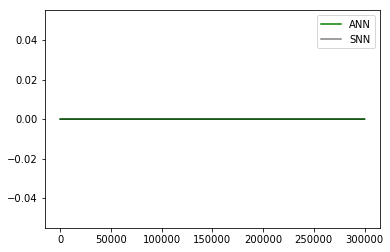

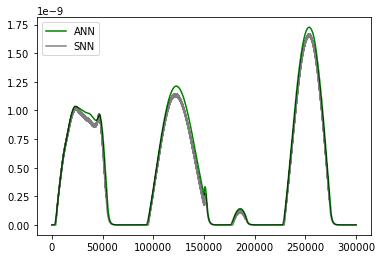

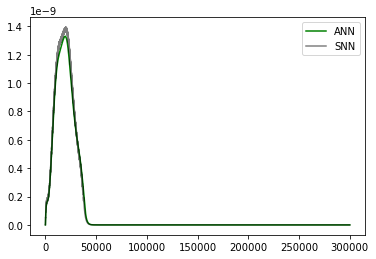

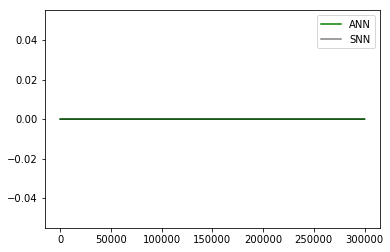

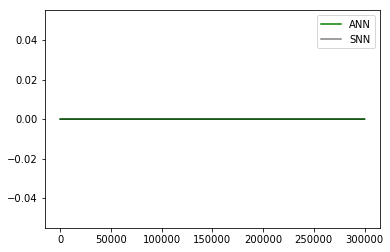

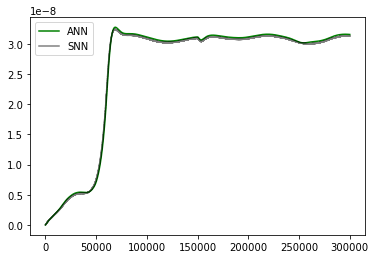

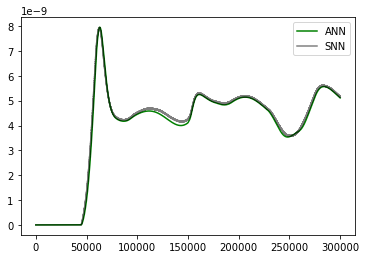

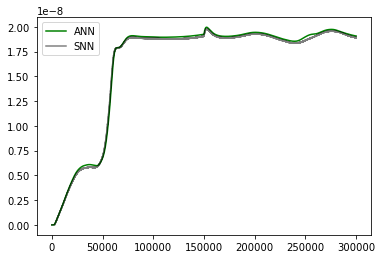

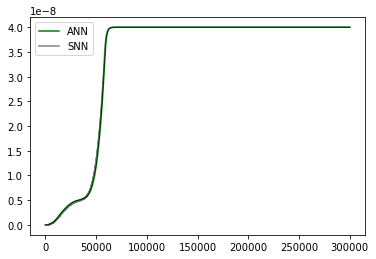

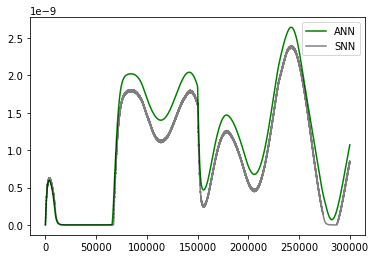

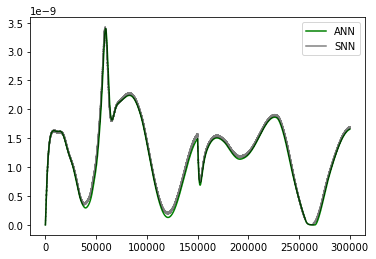

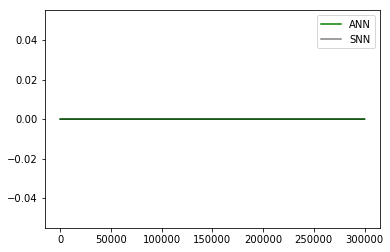

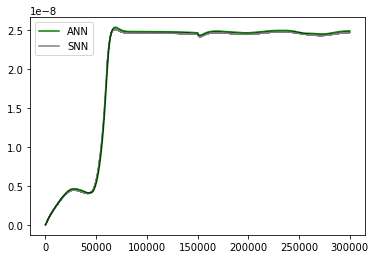

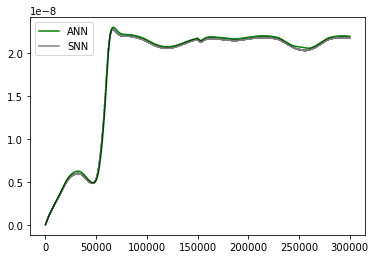

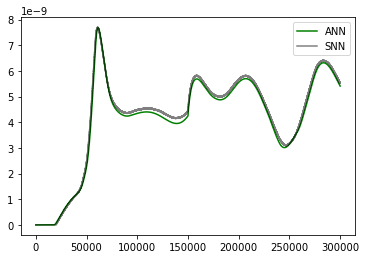

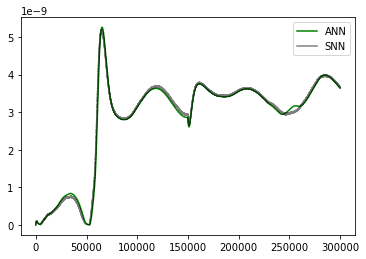

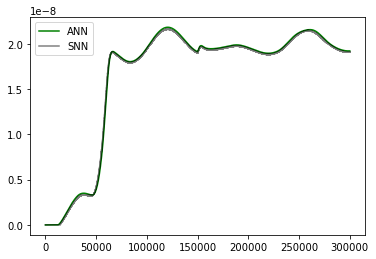

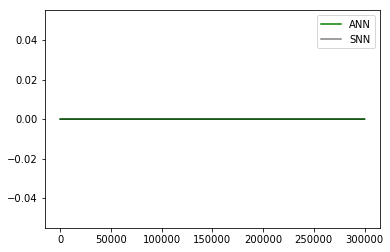

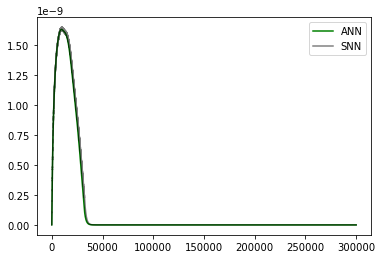

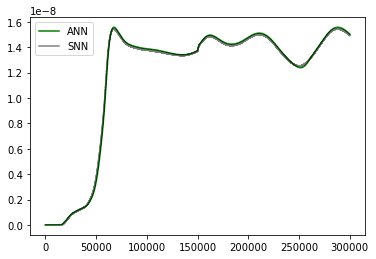

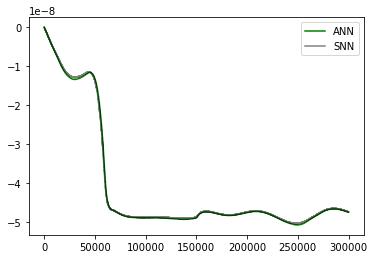

In [65]:
# Plotting and visualization
print('Time constant = {0:.3f} sec'.format(1/net.tau))
for idx in range(len(ann_states)):
    for jdx in range(ann_states[idx].shape[0]):
        plt.figure()
        plt.plot(ann_states[idx][jdx,:],'g', label='ANN')
        plt.legend()
        plt.plot(snn_states[idx][jdx,:],'k', label='SNN', alpha=0.5)
        plt.legend()
t = 0
for N in net.neurons:
    t += np.sum(N.spike_count)
print('Average spike rate = {0:.3f} KHz'. format(1e-3*t/(tsteps[-1]*op_dim+res_dim+ip_dim)))